In [1]:
import numpy as np
from scipy.optimize import fmin
from scipy.fft import fft, ifft
from scipy.linalg import lstsq
import math
import matplotlib.pyplot as plt
import numba

In [2]:
def tasseled_cap(data: np.ndarray) -> np.ndarray:
    """Tasseled Cap Transformation (TCT) is a linear transformation of Landsat 8 bands.

    Coefficients obtained from the paper: https://www.tandfonline.com/doi/full/10.1080/2150704X.2014.915434
    Can also be found at: https://yceo.yale.edu/tasseled-cap-transform-landsat-8-oli
    """
    tc_xform = np.array(
        [  # blue, green, red, NIR, SWIR1, SWIR2
            [0.3029, 0.2786, 0.4733, 0.5599, 0.508, 0.1872],  # Brightness
            [-0.2941, -0.243, -0.5424, 0.7276, 0.0713, -0.1608],  # Greenness
            [0.1511, 0.1973, 0.3283, 0.3407, -0.7117, -0.4559]  # Wetness
        ]
    )
    return np.einsum('ij,ljno->lino', tc_xform, data)

In [188]:
def fourier_series(x, t, order=4) -> np.float64:
    P = 365.2421891  # siderial days per year. Same as used in https://www.sciencedirect.com/science/article/abs/pii/S0924271618300066?via%3Dihub or https://www.fs.usda.gov/nrs/pubs/jrnl/2018/nrs_2018_wilson_001.pdf
    y = x[0] + x[1]*t
    n = 1
    for i in range(2, (2*order)+2, 2):
        print(i, n)
        y = y + x[i]*np.sin(2*n*np.pi*t/P) + x[i+1]*np.cos(2*n*np.pi*t/P)
        n += 1
    return y

In [4]:
def fit_func(x, t, target, order):
    pred = fourier_series(x, t, order)
    return np.sum((pred - target)**2)

In [209]:
# Produces a matrix that can be used as the A matrix in a least squares problem
def fourier_matrix(times, order=4, P=365.2421891):
    nt = len(times) # number of time steps
    A = np.ones((nt, (2*order+2))) # A[0] = 1 for the constant term
    A[:, 1] = times # linear term
    n = 1
    for i in range(2, (2*order)+2, 2):
        print(n)
        A[:, i] = np.sin(2*n*np.pi*times/P)
        A[:, i+1] = np.cos(2*n*np.pi*times/P)
        n += 1
    return A



In [210]:
data = np.ones((365, 10, 10, 3))
times = np.arange(2, 3, 1)
print(f"{times = }")    
A = fourier_matrix(times, order=4)
print(f"{A.shape = }")
print(A)

times = array([2])
1
2
3
4
A.shape = (1, 10)
[[1.         2.         0.0343988  0.99940819 0.06875688 0.99763345
  0.10303357 0.99467788 0.13718832 0.99054498]]


In [211]:
def lstsq(times, data, order=4):
    """Least squares fit of a fourier series to a target using scipy.linalg.lstsq
    
    Args:
        times (np.ndarray): 1D array of times
        data (np.ndarray): 4D array of data to fit. Axes are (time, band, y, x)
        order (int, optional): Order of the fourier series. Defaults to 4.
    """
    A = fourier_matrix(times, order=order)
    t, b, y, x = data.shape
    data = np.moveaxis(data, 0, -1)
    data = data.reshape(y*x*b, t)
    params, res, rank, s = np.linalg.lstsq(A, data.T, rcond=None)
    print(f"{params.shape = }")
    return params.reshape(2*order+2, b, y, x)


In [216]:
"""
Run the least squares fit with some fake data. 

This is just a sine wave with some noise added to it.
"""
times = np.arange(0, 1000, 1, dtype=np.float64)
# times = np.expand_dims(times, axis=(1,2,3))
A = fourier_matrix(times, order=4)

vals = np.sin((2*np.pi/365.2421891)*times)
lin = 0.002*times

noise = np.random.normal(scale=0.1, size=(len(times)))
nvals = vals + noise
nvals = nvals + lin
data = np.tile(nvals, (3,2,2,1))
data = np.moveaxis(data, -1, 0)

# t_size = np.ones((100, 1, 128, 128), dtype=np.float64)

# times = times
print(times.shape)
print(data.shape)
print(f"{A.shape = }")



1
2
3
4
(1000,)
(1000, 3, 2, 2)
A.shape = (1000, 10)


In [217]:

x = lstsq(times, data, order=4)


1
2
3
4
params.shape = (10, 12)


In [218]:
x.shape

(10, 3, 2, 2)

2 1
4 2
6 3
8 4


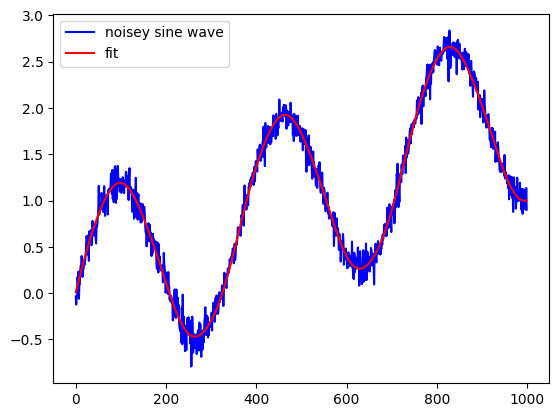

In [219]:
pred = fourier_series(x[:, 0, 0, 0], times, order=4)
target = data[:, 0, 0, 0]
plt.plot(target, color='blue', label='noisey sine wave')
plt.plot(pred, color='red', label='fit')
plt.legend()

In [38]:
# params = np.ones((9), dtype=np.float64)
params = np.array([0,1,0,0,0,0,0,0,0], dtype=np.float64)
params = np.tile(np.expand_dims(params, axis=0), (3, 1))
print(params.shape)
# res = fourier_series(params, times, order=4)
# print(res.shape)
# plt.plot(res)

(3, 9)


In [93]:
params = np.ones((9), dtype=np.float64)
res = fit_func(params, times, target, order=4)
print(res.shape)


()


In [94]:
min_params = params
for i in range(1):
    min_params = fmin(fit_func, min_params, args=(times, target, 4), disp=True)

Optimization terminated successfully.
         Current function value: 3.604752
         Iterations: 728
         Function evaluations: 1051


In [95]:
min_params

array([ 4.25087811e-04,  1.00098715e+00, -6.06162151e-03,  1.53055485e-02,
        7.47620828e-03, -1.57270300e-02, -1.23544230e-03, -1.57053361e-02,
       -1.38934098e-02])

In [96]:
pred = fourier_series(min_params, times, order=4)
pred.shape

(365,)

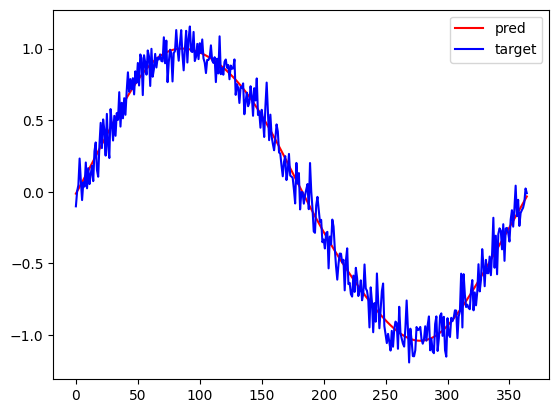

In [97]:
plt.plot(pred[:], color='red', label='pred')
plt.plot(target[:], color='blue', label='target')
plt.legend()

In [73]:
times = np.linspace(0,1, 100, dtype=np.float64)
# times = np.expand_dims(times, axis=(1,2,3))

vals = np.cos(10*2*np.pi*times) + np.cos(20*2* np.pi * times)
vals = np.expand_dims(vals, axis=(1,2,3))
t_size = np.ones((100, 1, 128, 128), dtype=np.float64)
target = t_size * vals

# noise = np.random.normal(scale=0.2, size=(100, 1, 128, 128))
# vals = vals + noise

print(target.shape)
print(times.shape)

(100, 1, 128, 128)
(100,)


In [74]:

xformed = fft(vals, axis=0)
xformed_abs = np.abs(xformed)

ixformed = ifft(xformed, axis=0)

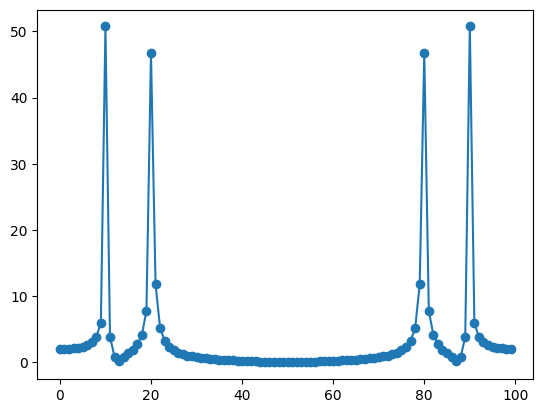

In [75]:
plt.plot(xformed_abs[:, 0, 0, 0], marker="o")

In [78]:
xformed_abs[0:30, 0, 0, 0]

array([ 2.        ,  2.01205831,  2.04949286,  2.11647176,  2.22149043,
        2.38086461,  2.62759769,  3.03756517,  3.83051047,  6.021117  ,
       50.73515638,  3.87458196,  0.85984544,  0.1842654 ,  0.81855681,
        1.35596286,  1.94557354,  2.75604623,  4.17356602,  7.79827576,
       46.70422302, 11.79492958,  5.18839129,  3.28841299,  2.38024058,
        1.84535453,  1.4915569 ,  1.23950731,  1.05041752,  0.90303979])

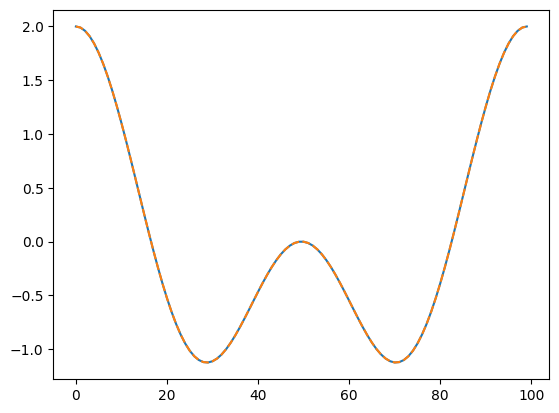

In [72]:
plt.plot(vals[:, 0, 0, 0])
plt.plot(ixformed[:, 0, 0, 0], ls="--")

In [224]:
from datetime import datetime
dts = np.datetime64(datetime(2020, 1,1), 'D')
dte = np.datetime64(datetime(2021, 1,1), 'D')
print(dte.astype(int) - dts.astype(int))

366


In [7]:
import ee
sa = "earth-engine@double-catfish-291717.iam.gserviceaccount.com"
creds = ee.ServiceAccountCredentials(sa, '/home/rob/.config/gcloud/gee.json')
ee.Initialize(creds)

In [8]:
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())

NASADEM: NASA NASADEM Digital Elevation 30m
